# **Signal Processing Assignment 1**

### <u>Question 2</u>: 

### Create the program sinsamp.m, and modify it from above to sample a sinusoid with frequency 20 Hz with a sampling rate of 200 Hz. Plot the results. Now sample the same signal with a sampling rate of 20 Hz and plot the results. Describe the effect of the change in sampling rate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

# plotting set up
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'
rc('font', family='sans-serif')
rc('font', weight='normal', size=15)
rc('figure', facecolor='white')

Sinusoid calculation

In [13]:
js = 0
samp_time = [1/200., 1/20.]
freq = 20
time = np.empty(1000)
x = np.empty(1000)

for i in range(1000):
    time[i] = i * samp_time[js]
    x[i] = np.cos(2*np.pi*freq*time[i])

Plot $x(t)$ vs. time

Text(0, 0.5, '$x(t)$')

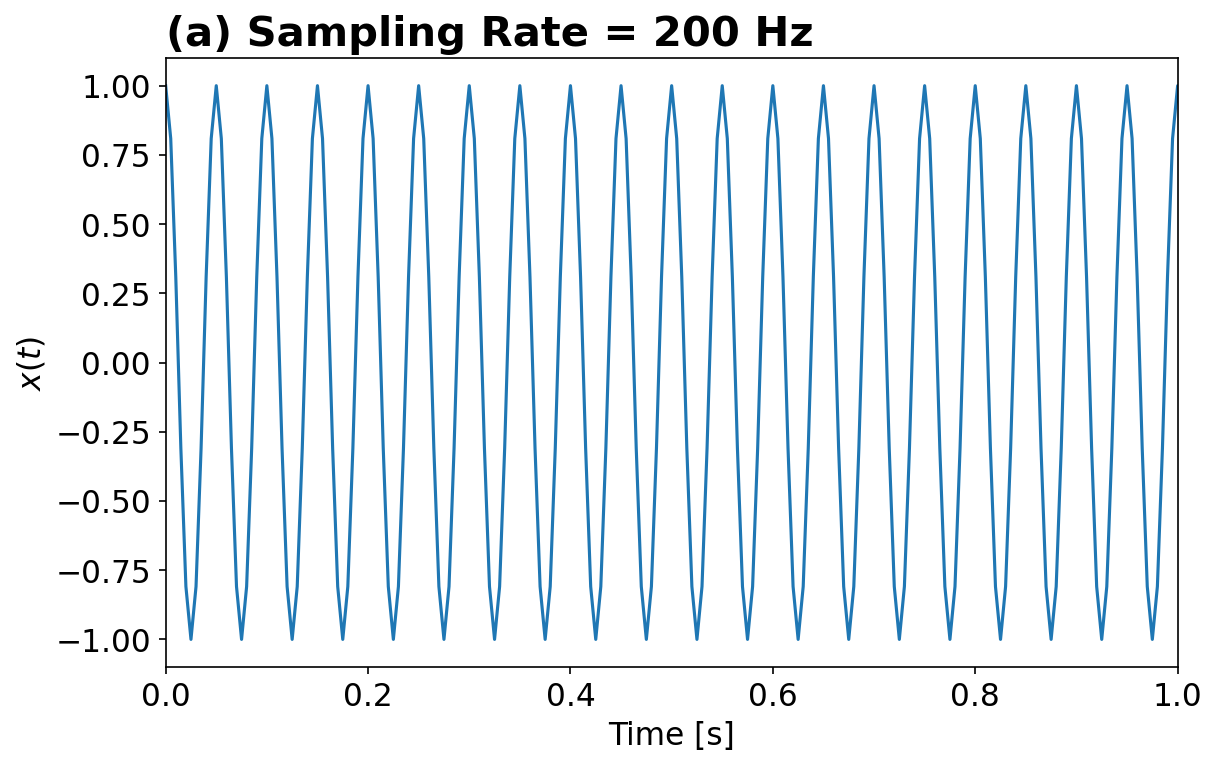

In [14]:
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True, dpi=150)

ax.plot(time, x)

labs = "ab"
ax.set_title(f"({labs[js]}) Sampling Rate = {int(1/samp_time[js])} Hz", 
             fontweight='bold', 
             loc='left',
             fontsize=20)
ax.set_xlim(0,1)
ax.set_xlabel('Time [s]')
ax.set_ylabel("$x(t)$")

### <u>Question 3</u>: 

### Please download data from the New Orleans, LA NEXRAD (KLIX) at 16:06:36 UTC on 29 August 2021 from the NCDC or AWS page (see Section 3.1). Read through the Basic Py-ART tutorial here, which is course notebook 5 (https://github.com/openradar/AMS_radar_in_the_cloud). 

### Using this notebook as a template, create your own Python script or notebook to plot radar reflectivity factor at 0.5-deg elevation for the date and time listed above using Py-ART’s plotppi command. Make sure your plot has labeled x and y axes and a descriptive title. If you follow the Py-ART tutorial, it should be automatically generated.

Read WSR-88D file

In [4]:
import pyart

drad = "/Users/robbyfrost/Documents/Classes/Radar_Theory/SPA1/KLIX_NEXRAD_20210829/KLIX20210829_160636_V06.ar2v"
radar = pyart.io.read(drad)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Check elevations

In [5]:
radar.fixed_angle['data']

array([ 0.48339844,  0.48339844,  0.48339844,  0.87890625,  0.87890625,
        0.87890625,  1.3183594 ,  1.3183594 ,  1.3183594 ,  1.8017578 ,
        0.48339844,  0.48339844,  0.48339844,  2.4169922 ,  3.1201172 ,
        3.9990234 ,  5.0976562 ,  6.4160156 ,  7.998047  , 10.019531  ,
       12.480469  , 15.600586  , 19.511719  ], dtype=float32)

Extract 0.5 $^{\circ}$ elevation sweep, format time string

In [6]:
swp = 0
radswp = radar.extract_sweeps([swp])
tplot = radar.time['units'][14:24] + " " + radar.time['units'][25:-1] + " UTC"
hx, hy = -35, -155

Plot reflectivity PPI

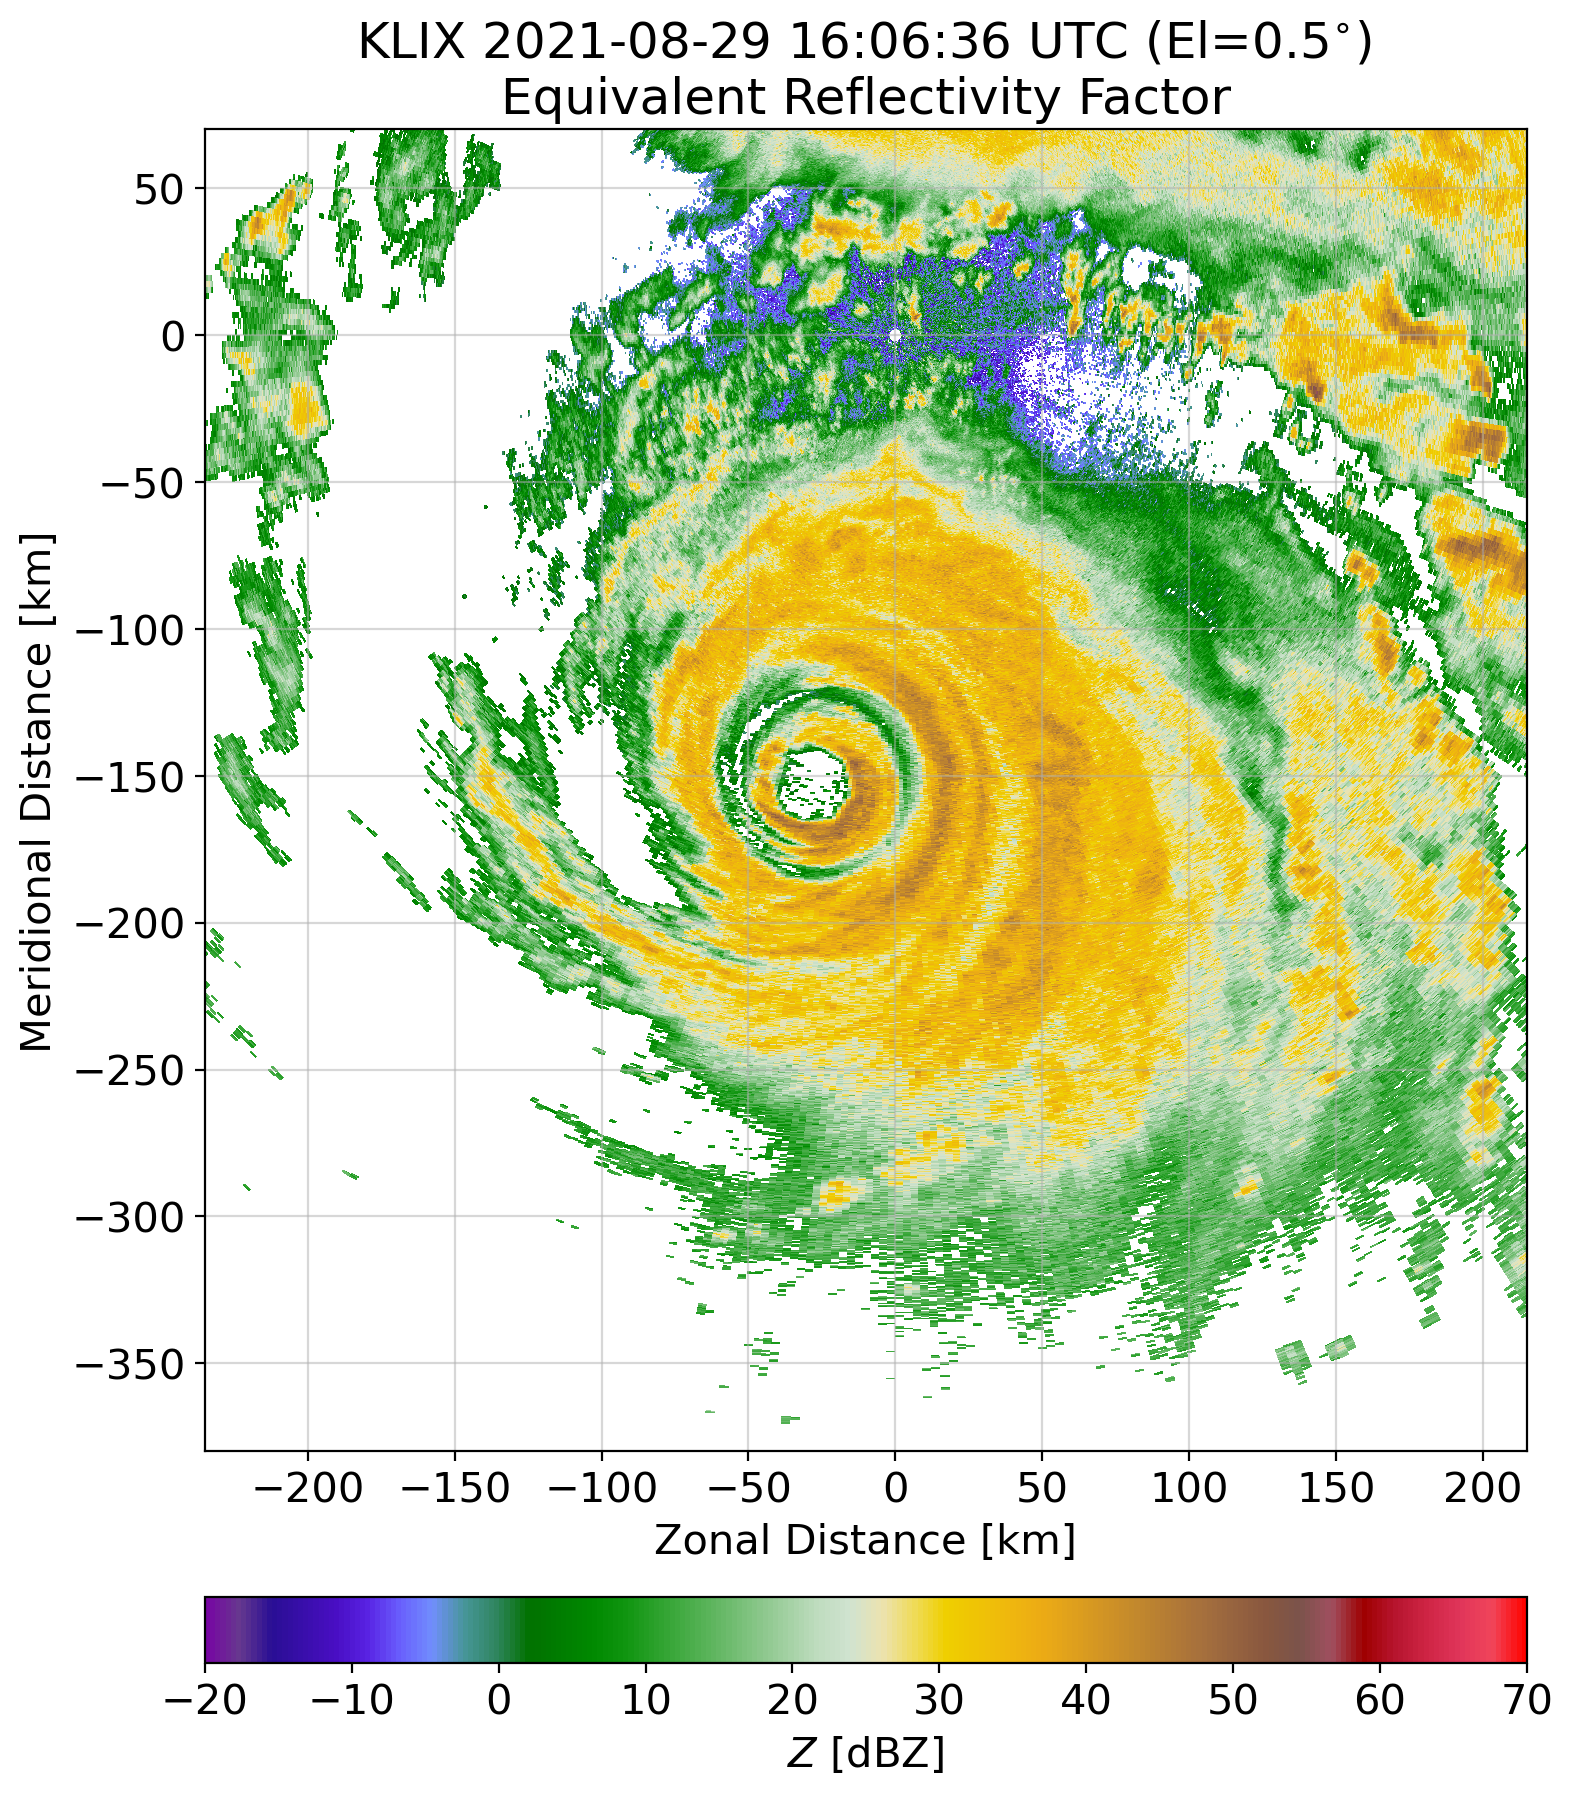

In [7]:
# make figure
display = pyart.graph.RadarDisplay(radswp)
fig, ax = plt.subplots(figsize=(7.75,9),
                        constrained_layout=True,
                        dpi=200)
# reflectivity
vmin, vmax = -20, 70
display.plot_ppi('reflectivity', ax=ax, 
                 vmin=vmin, vmax=vmax,
                 cmap="pyart_Carbone42",
                 colorbar_flag=False,
                 title_use_sweep_time=True,
                 axislabels_flag=False)
cbar0 = fig.colorbar(display.plots[0], ax=ax, orientation='horizontal', pad=0.025)
ax.set_title(f"KLIX {tplot} (El={radar.fixed_angle['data'][swp]:.1f}$^{{\\circ}}$) \nEquivalent Reflectivity Factor")
# clean up
cbar0.set_label("$Z$ [dBZ]")
cbar0.set_ticks(np.arange(vmin, vmax + 0.001, 10))
ax.set_xlabel("Zonal Distance [km]")
ax.set_ylabel("Meridional Distance [km]")
ax.set_aspect('equal')
ax.set_xlim(hx-200,hx+250)
ax.set_ylim(hy-225,hy+225)
ax.grid(alpha=0.5)

### <u>Question 4</u>: 

### Calculate the radar beam height assuming a 4/3-Earth’s radius model for propagation. On your PPI plots of radar reflectivity factor, use the Matlab contour and clabel functions (or Python equivalents) to plot and label radar beam height contours every 1 km AGL. 

### Based on your contours, what is the approximate height of the radar beam in the center of the eyewall for the 0.5-deg elevation scan at 16:06:36 UTC? Looking through successively higher elevation angles, what is the maximum height of echoes that you see within the eyewall?

Calculate ranges that coordespond to beam heights

In [8]:
# extract needed fields
swp = 13
radswp = radar.extract_sweeps([swp])
r = radswp.range['data']
az = radswp.azimuth['data']
rfull = np.full((az.size,r.size), r)
elrad = np.deg2rad(radar.fixed_angle['data'][swp])
ae = (4/3)*6.371*1e6

# calculate beam height
bh = (r**2 + ae**2 + 2*r*ae*np.sin(elrad))**(1/2) - ae
bh = np.full((az.size,r.size), bh)

# extract positions
x, y, _ = radar.get_gate_x_y_z(swp)

Replot PPI with range rings

In [9]:
# make figure
display = pyart.graph.RadarDisplay(radswp)
fig, ax = plt.subplots(figsize=(7.75,9),
                        constrained_layout=True,
                        dpi=200)

# reflectivity
vmin, vmax = -20, 70
display.plot_ppi('reflectivity', ax=ax, 
                 vmin=vmin, vmax=vmax,
                 cmap="pyart_Carbone42",
                 colorbar_flag=False,
                 title_use_sweep_time=True,
                 axislabels_flag=False)
cbar0 = fig.colorbar(display.plots[0], ax=ax, orientation='horizontal', pad=0.025)
ax.set_title(f"KLIX {tplot} (El={radar.fixed_angle['data'][swp]:.1f}$^{{\\circ}}$) \nEquivalent Reflectivity Factor")

# clean up
cbar0.set_label("$Z$ [dBZ]")
cbar0.set_ticks(np.arange(vmin, vmax + 0.001, 10))
ax.set_xlabel("Zonal Distance [km]")
ax.set_ylabel("Meridional Distance [km]")
ax.set_aspect('equal')
ax.set_xlim(hx-200,hx+250)
ax.set_ylim(hy-225,hy+225)

# plot range rings
bhlevs = np.arange(1,15.1,1)
c = ax.contour(x/1e3, y/1e3, bh/1e3,
               levels=bhlevs,
               colors='black',
               linestyles='--',
               linewidths=0.75)
ax.clabel(c, levels=bhlevs, fmt="%d km")

<a list of 14 text.Text objects>

### <u>Question 5</u>: 

### Modify the Python script to plot radar reflectivity factor and Doppler velocity from RaXPol data file. I suggest doing a Save As... on your previous Python script or copying and renaming it. Py-ART will automatically detect the type of radar data file as long as it is in a standard format (e.g., NEXRAD Level II, CF/Radial). So, you can just use the pyart.io.read command. However, the variable keys will have different names from the NEXRAD file above. Use the print(radar.fields.keys()) command to see how these variables are named. 

### Make plots of both radar reflectivity factor and Doppler velocity, adding appropriate axis labels and titles for your plots. Adjust the zoom to focus on the tornado (X limits between -10 and 0 km and Y limits between -10 and 0 km).

Read in radar data

In [10]:
drad = "/Users/robbyfrost/Documents/Classes/Radar_Theory/SPA1/raxpol_cfrad_20130531/cfrad.20130531_231212.000_to_20130531_231214.000_RaXPol_SUR.nc"

radar = pyart.io.read(drad)
tplot = radar.time['units'][14:24] + " " + radar.time['units'][25:-1] + " UTC"

# calculate inferred vertical vorticity
import sys
sys.path.append("/Users/robbyfrost/Documents/MS_Project/TurbTor_Radar/")
from functions import calc_vort_radar
radar = calc_vort_radar(radar, 'VEL', 'VORTZ', 3)

Plot $Z$ and $V_r$

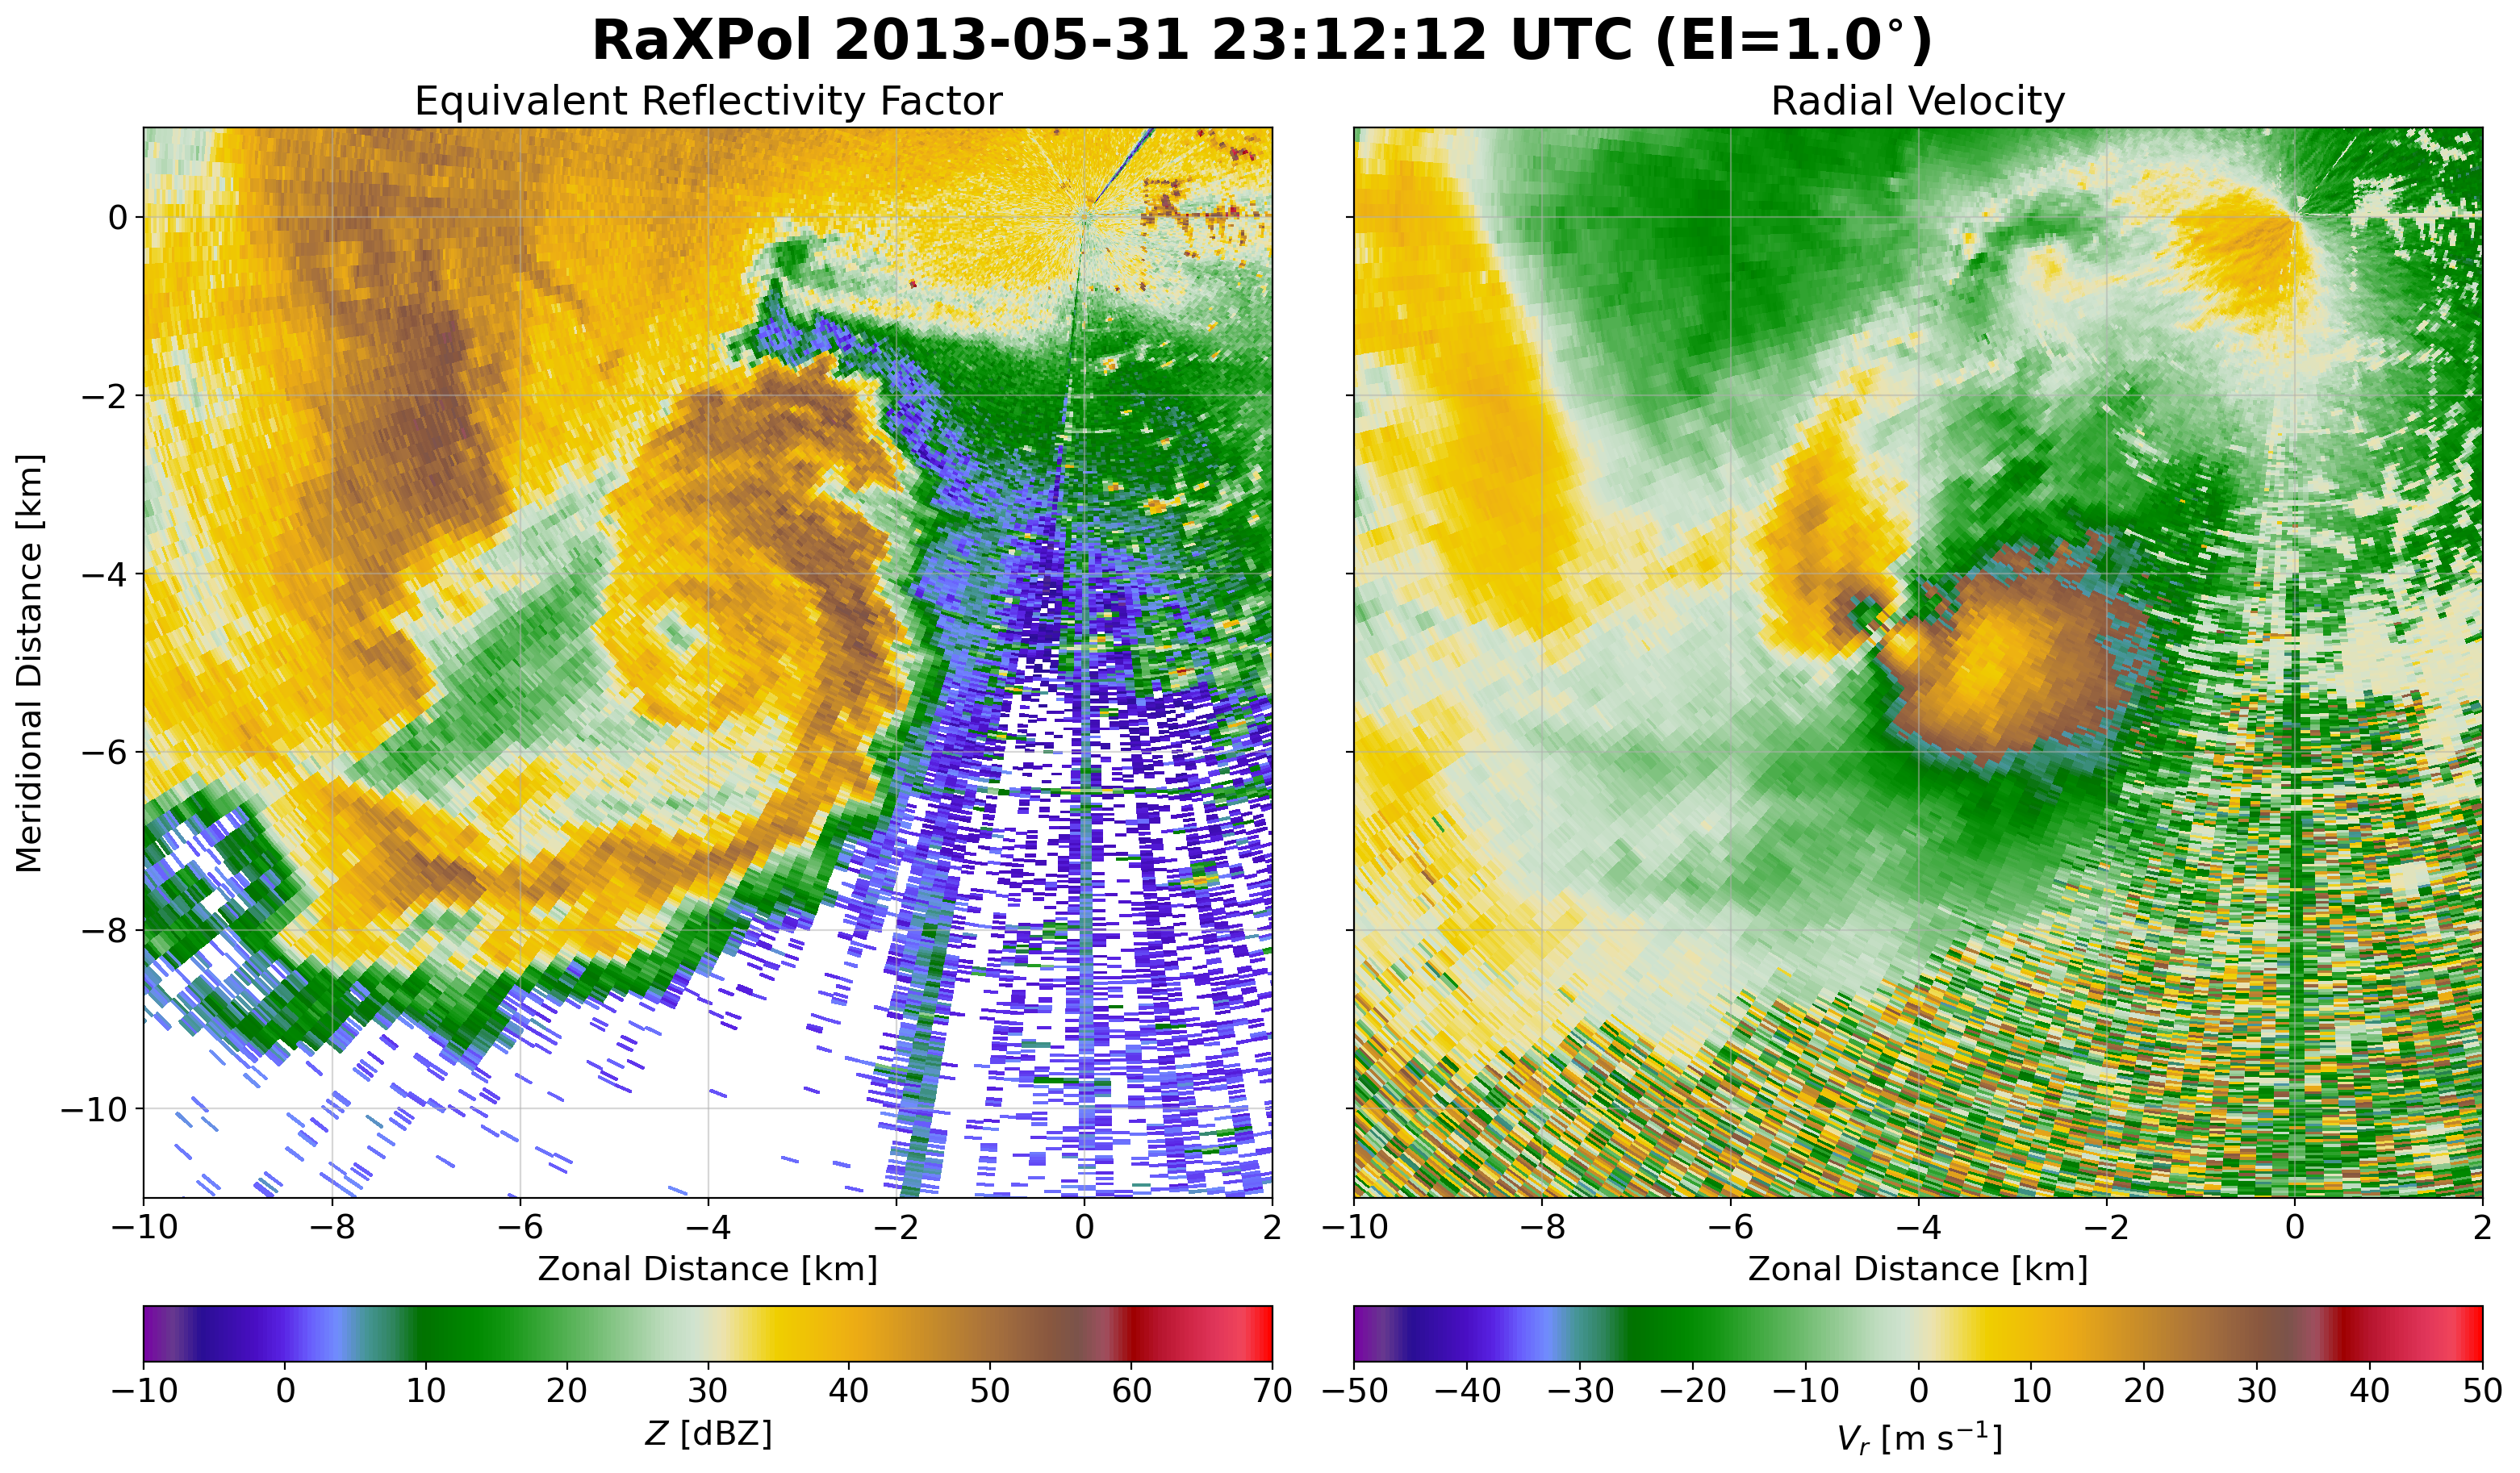

In [11]:
display = pyart.graph.RadarDisplay(radar.extract_sweeps([0]))
xlims = [-10,2]
ylims = [-11,1]

fig, axs = plt.subplots(figsize=(15.5,9), 
                        ncols=2,
                        constrained_layout=True,
                        dpi=200,
                        sharey=True)

fig.suptitle(f"{radar.metadata['instrument_name']} {tplot} (El={radar.fixed_angle['data'][0]:.1f}$\\bf{{^{{\\circ}}}}$)", fontsize=25, fontweight='bold')

# reflectivity
ax = axs[0]
vmin, vmax = -10, 70
display.plot_ppi('DBZ', ax=ax, 
                vmin=vmin, vmax=vmax,
                cmap="pyart_Carbone42",
                colorbar_flag=False,
                title_use_sweep_time=False,
                axislabels_flag=False)
ax.set_title("Equivalent Reflectivity Factor")
ax.set_ylabel("Meridional Distance [km]")
cbar0 = fig.colorbar(display.plots[0], ax=ax, orientation='horizontal', pad=0.015)
cbar0.set_label("$Z$ [dBZ]")
cbar0.set_ticks(np.arange(vmin, vmax + 0.001, 10))

# radial velocity
ax = axs[1]
vmin, vmax = -50, 50
display.plot_ppi('VEL', ax=ax, 
                vmin=vmin, vmax=vmax,
                cmap="pyart_Carbone42",
                colorbar_flag=False,
                title_use_sweep_time=False,
                axislabels_flag=False)
ax.set_title("Radial Velocity")
cbar2 = fig.colorbar(display.plots[1], ax=ax, orientation='horizontal', pad=0.015)
cbar2.set_label("$V_r$ [m s$^{-1}$]")
cbar2.set_ticks(np.arange(vmin, vmax + 0.001, 10))

for ax in axs:
    ax.set_xlabel("Zonal Distance [km]")
    ax.grid(alpha=0.5)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)